### Coursework 1

# This notebook was used for the implementation and hyperparameter tuning purposes and it is not to be assumed as my final work!

In this coursework you will be aiming to complete two classification tasks. One of the classification tasks is related to image classification and the other relates to text classification.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single PDF file. You could have additional functions implemented that you require for carrying out each task.

#### Task 1

In this task, you are provided with three classes of images, cars, bikes and people in real world settings. You are provided with code for obtaining features for these images (specifically histogram of gradients (HoG) features). You need to implement a boosting based classifier that can be used to classify the images. 

This task is worth 30 points out of 100 points. 
Implementing a working boosting based classifier and validating it by cross-validation on the training set will be evaluated for 15 out of 30 points. 10 points are based on the evaluation carried out on a separate test dataset that will be done at the time of evaluation. Finally 5 points are reserved for analysis of this part of the task and presenting it well in a lab report. 

Note that the boosting classifier you implement can include decision trees from your previous ML1 coursework or can be a decision stump. Use the image_dataset directory provided with the assignment and save it in the same directory as the Python notebook

#### Write your  Image feature extraction code

In [1]:
import numpy as np
import cv2
import glob
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import KFold, cross_val_score
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def obtain_dataset(folder_name):
    # assuming 128x128 size images and HoGDescriptor length of 34020
    hog_feature_len=34020
    hog = cv2.HOGDescriptor()
    
    X = np.empty([0,hog_feature_len], dtype=float)
    ytargets = []
    
    directories_list = ['bikes', 'people', 'cars']
    for directory in directories_list:
        for filename in glob.glob(folder_name+'/'+directory+'/*.png'):
            
            im = cv2.imread(filename)
            h = hog.compute(im).reshape(1,-1)

            X = np.append(X, h, axis=0)
            ytargets.append(directory)

    y = np.array(ytargets)

    return (X,y)


#### Boosting classifier class

In [3]:
class BoostingClassifier:

    def __init__(self, num_classifiers):
        
        self.num_classifiers = num_classifiers
        self.classifiers = []
        self.classes = []
    
    def fit(self, X,y):
        
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
#         if len(self.classes) == 3:
#             # M for images
#             self.num_classifiers = 62
#         elif len(self.classes) == 2:
#             # M for text
#             self.num_classifiers = 350
        
        # Initialize weights to 1/N
        weights = np.full(n_samples, (1 / n_samples), dtype=np.float32)
        
        for classifier_index in range(self.num_classifiers):
            classifier_tm = DecisionTreeClassifier(max_depth=1).fit(X,y,sample_weight=weights).predict
            
            I = np.where(classifier_tm(X) != y, 1, 0)
            errM = sum(weights * I) / sum(weights)
            
            aM = np.log((1-errM)/errM) + np.log(len(self.classes)-1)
        
            for i in range(weights.shape[0]):
                weights[i] = weights[i]*np.exp(aM*I[i])
        
            self.classifiers.append((aM, classifier_tm))
        
    
    def predict(self, X):
        classes = self.classes
        
        predictions = np.zeros([X.shape[0],1])
        # Through each class
        for clas in classes:
            
            class_sum = np.zeros([X.shape[0], 1])
            
            # Through each classifier
            for classifier_index in range(self.num_classifiers):
                
                aM, classifier_tm = self.classifiers[classifier_index]

                # To update sum
                I = np.expand_dims(np.where(classifier_tm(X) == clas, 1, 0), axis=1)
                class_sum += aM * I
                
            predictions = np.append(predictions, class_sum, axis=1)
        
        predictions = predictions[:,1:]

        index_predictions = np.argmax(predictions, axis=1)

        classes_array = np.array(classes)
        y_pred = classes_array[index_predictions]
        
        return y_pred


#### Obtain the train,test split and test for optimal M value

In [ ]:
train_folder_name='image_dataset'

(X_data, Y_data) = obtain_dataset(train_folder_name)

# Shuffling to prevent bias
randomize = np.arange(len(X_data))
np.random.shuffle(randomize)

X_data = X_data[randomize]
Y_data = Y_data[randomize]

k_fold = KFold(n_splits=5)
classifiers_list = [i for i in range(5, 155, 5)]

num_class_accuracy = []

for num_classifiers in classifiers_list:

    acc_scores = []
    
    for train_indices, test_indices in k_fold.split(X_data):
  
        bc = BoostingClassifier(num_classifiers)
        bc.fit(X_data[train_indices], Y_data[train_indices])
        y_pred = bc.predict(X_data[test_indices])
        accuracy = accuracy_score(Y_data[test_indices], y_pred)
        acc_scores.append(accuracy)
    
    num_class_accuracy.append(np.mean(acc_scores))
    
    print(num_classifiers, '> AVG accuracy: ', round(np.mean(acc_scores), 2))

#### Train the boosting classifer and evaluate it on the train-test split

In [ ]:
# Simple learning curve
print(max(num_class_accuracy))
plt.plot(classifiers_list, num_class_accuracy)
plt.axhline(max(num_class_accuracy), color='k', alpha=0.5, linestyle='--')
plt.xlabel("Number of Classifiers (M)")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
train_folder_name='image_dataset'

(X_data, Y_data) = obtain_dataset(train_folder_name)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_data, Y_data, train_size=0.8)

bc = BoostingClassifier(155)
bc.fit(Xtrain, ytrain)
y_pred = bc.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print('> accuracy', round(accuracy, 3))

### Test function that will be called to evaluate your code. Separate train and test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. We will also be evaluating the cross-validation performance with a set train and val split.

In [ ]:
def test_func_boosting_image(image_dataset_train, image_dataset_test):
    (X_train, Y_train) = obtain_dataset(image_dataset_train)
    (X_test, Y_test) = obtain_dataset(image_dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    y_pred = bc.predict(X_test)
    print('accuracy', accuracy_score(Y_test, y_pred))
    return y_pred

#### Task 2

In this task, you need to classify the above dataset using a Support Vector Machine (SVM).

This task is worth 25 points out of 100 points. You are allowed to use existing library functions such as scikit-learn for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom kernels. The marking will be 15 marks for analysing the dataset using various kernels including your own kernels, 5 points for the performance on the test dataset and 5 points for a lab-report that provides the analysis and comparisons.

In [4]:
class SVMClassifier:
 
    def __init__(self, kernel):
        self.image_classifier = None
        self.text_classifier = None
        # Change the name of this parameter to test the other kenrnels
        # ['linear', 'poly', 'rbf', 'sigmoid','laplacian', 'log', 'cauchy']
        self.image_kernel = kernel
        self.text_kernel = kernel
#         self.image_kernel = 'laplacian'
#         self.text_kernel = 'log'

        self.image_X_train = None
        self.text_X_train = None

    def fit_image(self, X, y):
        #training of the SVM 
        # providing for separate image kernels 
        
        if self.image_kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            clf = svm.SVC(kernel=self.image_kernel)
            clf.fit(X, y)
        else:
            clf = svm.SVC(kernel='precomputed')
            
            if self.image_kernel == 'laplacian':
                kernel_train = self.laplacian_kernel(X, X)
                
            elif self.image_kernel == 'log':
                kernel_train = self.log_kernel(X, X)

            elif self.image_kernel == 'cauchy':
                kernel_train = self.cauchy_kernel(X, X)
                        
            clf.fit(kernel_train, y)
            self.image_X_train = X
        
        self.image_classifier = clf
    
    def fit_text(self, X,y):
        # training of the SVM

        if self.text_kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            clf = svm.SVC(kernel=self.text_kernel)
            clf.fit(X, y)
        else:
            clf = svm.SVC(kernel='precomputed')
            
            if self.text_kernel == 'laplacian':
                kernel_train = self.laplacian_kernel(X, X)
                
            elif self.text_kernel == 'log':
                kernel_train = self.log_kernel(X, X)

            elif self.text_kernel == 'cauchy':
                kernel_train = self.cauchy_kernel(X, X)
                        
            clf.fit(kernel_train, y)
            self.text_X_train = X
        
        self.text_classifier = clf
    
    
    def predict_image(self, X):
        # prediction routine for the SVM
        
        clf = self.image_classifier
        
        if self.image_kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            y_pred = clf.predict(X)
            
        else:
            X_train = self.image_X_train
            
            if self.image_kernel == 'laplacian':
                kernel_test = self.laplacian_kernel(X, X_train)
                
            elif self.image_kernel == 'log':
                kernel_test = self.log_kernel(X, X_train)

            elif self.image_kernel == 'cauchy':
                kernel_test = self.cauchy_kernel(X, X_train)
        
            y_pred = clf.predict(kernel_test)
        
        return y_pred
        

    def predict_text(self, X):
        # prediction routine for the SVM
        clf = self.text_classifier
        
        if self.text_kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            y_pred = clf.predict(X)
            
        else:
            X_train = self.text_X_train
            
            if self.text_kernel == 'laplacian':
                kernel_test = self.laplacian_kernel(X, X_train)
                
            elif self.text_kernel == 'log':
                kernel_test = self.log_kernel(X, X_train)

            elif self.text_kernel == 'cauchy':
                kernel_test = self.cauchy_kernel(X, X_train)
        
            y_pred = clf.predict(kernel_test)
        
        return y_pred
    
    def laplacian_kernel(self, X, y):
        import numpy as np
        from sklearn.metrics.pairwise import euclidean_distances
        import scipy
        
        if scipy.sparse.issparse(X):
            sigma = np.sqrt(X.shape[1] * np.var(X.toarray()))
        else:
            sigma = np.sqrt(X.shape[1] * np.var(X))

        euclid_dist = euclidean_distances(X, y)
        result = (- euclid_dist/ sigma)

        return result
    
    
    def log_kernel(self, X, y):
        import numpy as np
        from sklearn.metrics.pairwise import euclidean_distances

        d = 1
        euclid_dist = euclidean_distances(X, y)
        result = -np.log(euclid_dist**d + 1)
        return result

    
    def cauchy_kernel(self, X, y):
        import numpy as np
        from sklearn.metrics.pairwise import euclidean_distances
        import scipy

        if scipy.sparse.issparse(X):
            sigma = X.shape[1] * np.var(X.toarray())
        else:
            sigma = X.shape[1] * np.var(X)
            
        euclid_dist = euclidean_distances(X, y)

        result = 1 / (1+ (euclid_dist**2 / sigma**2))
        return result
 

#### Train the SVM classifer and evaluate it on the train-test split

In [5]:
image_kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'laplacian', 'log', 'cauchy']
kernels_df = pd.DataFrame([], columns=image_kernels)

for _ in range(10):

    train_folder_name='image_dataset'

    (X_data, Y_data) = obtain_dataset(train_folder_name)

    # Shuffling to prevent bias
    randomize = np.arange(len(X_data))
    np.random.shuffle(randomize)

    X_data = X_data[randomize]
    Y_data = Y_data[randomize]

    k_fold = KFold(n_splits=10)
    
    kernel_accuracy = []

    for kernel in image_kernels:

        acc_scores = []

        for train_indices, test_indices in k_fold.split(X_data):

            sc = SVMClassifier(kernel)
            sc.fit_image(X_data[train_indices], Y_data[train_indices])
            y_pred = sc.predict_image(X_data[test_indices])
            accuracy = accuracy_score(Y_data[test_indices], y_pred)
            acc_scores.append(accuracy)

        kernel_accuracy.append(np.mean(acc_scores))

        print('Kernel:', kernel, '| Accuracy: ', round(np.mean(acc_scores), 2))
        
    df_temp = pd.DataFrame([kernel_accuracy], columns=image_kernels)
    kernels_df = kernels_df.append(df_temp, ignore_index = True)


Kernel: linear | Accuracy:  0.5
Kernel: poly | Accuracy:  0.49
Kernel: rbf | Accuracy:  0.47
Kernel: sigmoid | Accuracy:  0.21
Kernel: laplacian | Accuracy:  0.5
Kernel: log | Accuracy:  0.47
Kernel: cauchy | Accuracy:  0.23
Kernel: linear | Accuracy:  0.51
Kernel: poly | Accuracy:  0.51
Kernel: rbf | Accuracy:  0.49
Kernel: sigmoid | Accuracy:  0.19
Kernel: laplacian | Accuracy:  0.49
Kernel: log | Accuracy:  0.51
Kernel: cauchy | Accuracy:  0.19
Kernel: linear | Accuracy:  0.51
Kernel: poly | Accuracy:  0.51
Kernel: rbf | Accuracy:  0.5
Kernel: sigmoid | Accuracy:  0.25
Kernel: laplacian | Accuracy:  0.51
Kernel: log | Accuracy:  0.5
Kernel: cauchy | Accuracy:  0.24
Kernel: linear | Accuracy:  0.47
Kernel: poly | Accuracy:  0.46
Kernel: rbf | Accuracy:  0.47
Kernel: sigmoid | Accuracy:  0.25
Kernel: laplacian | Accuracy:  0.51
Kernel: log | Accuracy:  0.51
Kernel: cauchy | Accuracy:  0.27
Kernel: linear | Accuracy:  0.51
Kernel: poly | Accuracy:  0.5
Kernel: rbf | Accuracy:  0.49
Ker

linear       0.497333
poly         0.490000
rbf          0.484667
sigmoid      0.228000
laplacian    0.502000
log          0.484667
cauchy       0.236000
dtype: float64


[Text(0.5, 0, ''), Text(0, 0.5, 'Accuracy')]

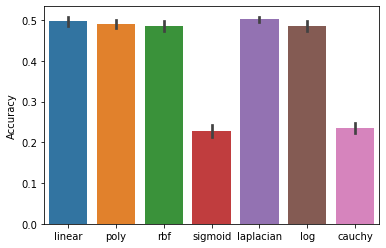

In [6]:
import seaborn as sns
print(kernels_df.mean())
kernelplot = sns.barplot(data=kernels_df)
kernelplot.set(xlabel='', ylabel='Accuracy')

In [ ]:
sc = SVMClassifier('laplacian')
sc.fit_image(Xtrain, ytrain)
y_pred = sc.predict_image(Xtest)
print('accuracy', accuracy_score(ytest, y_pred))

### Test function that will be called to evaluate your code. Separate train and test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. We will also be evaluating the cross-validation performance with a set train and val split.

In [ ]:
def test_func_svm_image(image_dataset_train, image_dataset_test):
    (X_train, Y_train) = obtain_dataset(image_dataset_train)
    (X_test, Y_test) = obtain_dataset(image_dataset_test)
    sc = SVMClassifier()
    sc.fit_image(X_train, Y_train)
    y_pred = sc.predict_image(X_test)
    print('accuracy', accuracy_score(Y_test, y_pred))
    return y_pred

#### Task 3

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train a boosting based classifier to obtain train and cross-validate on the dataset provided. The method will be evaluated against an external test set.

This task is worth 25 points out of 100 points. 15 points will be for implementing the pre-processing and Bag of Words based feature extractor correctly and evaluating the boosting based classifier for the text features and validating it by cross-validation on the training set. 5 points are based on the evaluation carried out on a separate test dataset that will be done at the time of evaluation. Finally 5 points are reserved for analysis of this part of the task and presenting it well in a lab report.

Use the movie_review_train.csv file provided with the assignment, and save it in the same directory as the Python notebook

#### Process the text and obtain a bag of words-based features 

In [19]:
def extract_bag_of_words(train_file):
    # Write your preprocessor to process the text
    # Write your own bag of words feature extractor using nltk and scikit-learn
    # return (X_train,y_train,X_test,y_test)
    
    # Process training data first and ensure the test data is not used while extracting bag of words feature vector
    import numpy as np
    import pandas as pd
    from sklearn.feature_extraction.text import CountVectorizer
    from nltk.tokenize import RegexpTokenizer
    
    train_data = pd.read_csv(train_file)
    # Shuffling to remove bias
    train_data = train_data.sample(frac=1)

    x_train = train_data['review']
    y_train = train_data['sentiment']
    
    token = RegexpTokenizer(r'[a-z]+')
    count_vect = CountVectorizer(lowercase=True, stop_words='english', tokenizer=token.tokenize)
    X_train = count_vect.fit_transform(x_train)
    
    return X_train, y_train


In [20]:
def extract_bag_of_words_train_test(train_file, test_file):
    # Write your preprocessor to process the text
    # Write your own bag of words feature extractor using nltk and scikit-learn
    # return (X_train,y_train,X_test,y_test)
    
    # Process training data first and ensure the test data is not used while extracting bag of words feature vector
    import numpy as np
    import pandas as pd
    from sklearn.feature_extraction.text import CountVectorizer
    from nltk.tokenize import RegexpTokenizer
    
    train_data = pd.read_csv(train_file)
    # Shuffling to remove bias
    train_data = train_data.sample(frac=1)
    
    x_train = train_data['review']
    y_train = train_data['sentiment']
    
    count_vect = CountVectorizer()
    X_train = count_vect.fit_transform(x_train)

    # Process testing data here. Ensure that test data is not used above
    test_data = pd.read_csv(test_file)

    x_test_data = test_data['review']
    y_test = test_data['sentiment']
    
    X_test = count_vect.transform(x_test_data)

    return X_train, y_train, X_test, y_test


In [21]:
train_file_name='movie_review_train.csv'

(X_train, Y_train) = extract_bag_of_words(train_file_name)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, train_size=0.8, random_state=1)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(4000, 38198) (1000, 38198) (4000,) (1000,)


In [18]:
bc = BoostingClassifier(350)
bc.fit(Xtrain, ytrain)
y_pred = bc.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print('> accuracy', round(accuracy, 3))

> accuracy 0.803


In [ ]:
num_class_cols = ['num_classifier', 'acccuracies']
# num_class_df = pd.DataFrame([], columns=num_class_cols)

# classifiers_list = [i for i in range(2, 121, 2)]
classifiers_list = [150, 175, 200, 250, 300, 350, 400]

for num_classifiers in classifiers_list:
        
    for _ in range(10):
        
        train_file_name='movie_review_train.csv'
        (X_train, Y_train) = extract_bag_of_words(train_file_name)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, train_size=0.8, random_state=1)
        
        df_scores = [num_classifiers]
        
        bc = BoostingClassifier(num_classifiers)
        bc.fit(Xtrain, ytrain)
        y_pred = bc.predict(Xtest)
        accuracy = accuracy_score(ytest, y_pred)
        df_scores.append(accuracy)
        
        df_temp = pd.DataFrame([df_scores], columns=num_class_cols)
        num_class_df = num_class_df.append(df_temp, ignore_index = True)    

    print(num_classifiers, '> AVG accuracy: ', round(num_class_df[num_class_df['num_classifier']==num_classifiers].mean().values[1], 3))        

In [ ]:
import seaborn as sns

sns.lineplot(data=num_class_df, x='num_classifier', y='acccuracies')

### Test function that will be called to evaluate your code. Separate train and test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. We will also be evaluating the cross-validation performance with a set train and val split.

In [ ]:
def test_func_boosting_text(text_dataset_train, text_dataset_test):
    (X_train, Y_train) = extract_bag_of_words(text_dataset_train)
    (X_test, Y_test) = extract_bag_of_words(text_dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    y_pred = bc.predict(X_test)    
    print('accuracy', accuracy_score(Y_test, y_pred))
    return y_pred

#### Task 4

In this task, you need to classify the above movie review dataset using a Support Vector Machine (SVM).

This task is worth 20 points out of 100 points. You are allowed to use existing library functions such as scikit-learn for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. The marking will be 10 marks for analysing the dataset using various kernels including your own kernels, 5 points for the performance on the test dataset and 5 points for a lab-report that provides the analysis and comparisons.

In [ ]:
text_kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'laplacian', 'log', 'cauchy']
text_df_cols = ['kernel', 'accuracy']

text_kernels_df = pd.DataFrame([], columns=text_df_cols)

for kernel in text_kernels:
        
    for _ in range(15):
        
        train_file_name='movie_review_train.csv'
        (X_train, Y_train) = extract_bag_of_words(train_file_name)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, train_size=0.8, random_state=1)
        
        df_scores = [kernel]
        
        sc = SVMClassifier(kernel)
        sc.fit_text(Xtrain, ytrain)
        y_pred = sc.predict_text(Xtest)
        accuracy = accuracy_score(ytest, y_pred)
        df_scores.append(accuracy)
        
        df_temp = pd.DataFrame([df_scores], columns=text_df_cols)
        text_kernels_df = text_kernels_df.append(df_temp, ignore_index = True)    
        
    print(kernel, '> AVG accuracy: ', round(text_kernels_df[text_kernels_df['kernel']==kernel].mean().values[0], 3))        

In [ ]:
import seaborn as sns

print(text_kernels_df.groupby('kernel')['accuracy'].mean())
kernel_text_plot = sns.barplot(data=text_kernels_df, x='kernel', y='accuracy')
kernel_text_plot.set(xlabel='', ylabel='Accuracy')

In [ ]:
# your code for svm based training of the dataset
# ['linear', 'poly', 'rbf', 'sigmoid', 'laplacian', 'log', 'cauchy']
train_file_name='movie_review_train.csv'

(X_train, Y_train) = extract_bag_of_words(train_file_name)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, train_size=0.8, random_state=1)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

sc = SVMClassifier('log')
sc.fit_text(Xtrain, ytrain)
y_pred = sc.predict_text(Xtest)
print('accuracy', accuracy_score(ytest, y_pred))

### Test function that will be called to evaluate your code. Separate train and test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. We will also be evaluating the cross-validation performance with a set train and val split.

In [ ]:
def test_func_svm_text(text_dataset_train, text_dataset_test):
    (X_train, Y_train) = extract_bag_of_words(text_dataset_train)
    (X_test, Y_test) = extract_bag_of_words(text_dataset_test)
    sc = SVMClassifier()
    sc.fit_text(X_train, Y_train)
    y_pred = sc.predict_text(X_test)
    print('accuracy', accuracy_score(Y_test, y_pred))
    return y_pred